In [1]:
#@title Download L5 Sample Dataset and install L5Kit
import os
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    !wget https://raw.githubusercontent.com/lyft/l5kit/master/examples/setup_notebook_colab.sh -q
    !sh ./setup_notebook_colab.sh
    os.environ["L5KIT_DATA_FOLDER"] = open("./dataset_dir.txt", "r").read().strip()
else:
    os.environ["L5KIT_DATA_FOLDER"] = "/mnt/scratch/v_liuhaolan/l5kit_data"
    print("Not running in Google Colab.")

Not running in Google Colab.


In [2]:
import matplotlib.pyplot as plt

import numpy as np

from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset

from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from tqdm import tqdm
from collections import Counter
from l5kit.data import PERCEPTION_LABELS
from prettytable import PrettyTable

import os

from l5kit.visualization.visualizer.zarr_utils import zarr_to_visualizer_scene
from l5kit.visualization.visualizer.visualizer import visualize
from bokeh.io import output_notebook, show
from l5kit.data import MapAPI

In [3]:
# Dataset is assumed to be on the folder specified
# in the L5KIT_DATA_FOLDER environment variable

# get config
cfg = load_config_data("./visualization_config.yaml")
print(cfg)

{'format_version': 4, 'debug': True, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 4, 'future_num_frames': 12, 'step_time': 0.1, 'render_ego_history': True}, 'raster_params': {'raster_size': [128, 128], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'val_data_loader': {'key': 'scenes/train_full.zarr', 'batch_size': 64, 'shuffle': True, 'num_workers': 16}}


In [4]:
dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   134622   |  33437057  | 2655096629 |   314473872   |      928.68     |        248.38        |        79.41         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [5]:
rast = build_rasterizer(cfg, dm)
dataset = EgoDataset(cfg, zarr_dataset, rast)

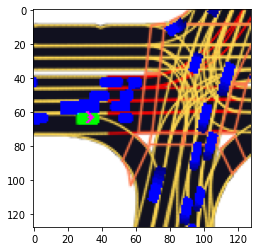

In [16]:
idx = 7890
#idx = 15344
data = dataset[idx]



#im = data["image"].transpose(1, 2, 0)
im = data["image"].transpose(1,2,0)
im = dataset.rasterizer.to_rgb(im)

target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])
"""
import matplotlib.patches as patches

rect = patches.Rectangle((32, 32), 64, 64, linewidth=2, edgecolor='r', facecolor='none')
fig, ax = plt.subplots()

plt.axis('off')

plt.imshow(im)

ax.add_patch(rect)
"""
plt.imshow(im)

plt.show()




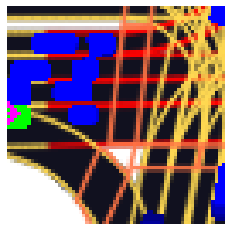

In [7]:
#print(im.shape)
img = im[32:96, 32:96, :]
plt.imshow(img)

#ax.add_patch(rect)
plt.axis('off')

plt.show()


0.02263665199279785


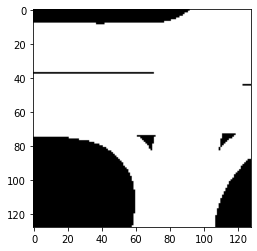

In [8]:

import time
start = time.time()
mask = dataset[idx]["road_mask"]
print(time.time()-start)

# In fact 0.1 seconds that looks good to me..
#plt.axis('off')
plt.imshow(mask, cmap=plt.get_cmap('gray'))


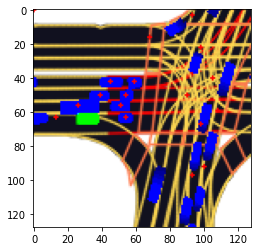

In [9]:
#data = dataset[idx]
# 65 is with perturb!


#im = data["image"].transpose(1, 2, 0)
im = data["image"].transpose(1,2,0)
im = dataset.rasterizer.to_rgb(im)

#target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
#draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])
im= np.ascontiguousarray(im, dtype=np.uint8)
import cv2
ocg = data["ocg"]
for i in ocg:
#    print(i)
    cv2.circle(im, (int(i[0]), int(i[1])), radius=1, color=(255, 0, 0), thickness=-1)


plt.imshow(im)
plt.show()

In [10]:
import math
def gaussian(xL, yL, H, W, sigma=2):

    channel = [0.5*math.exp(-((c - xL) ** 2 + (r - yL) ** 2) / (2 * sigma ** 2)) for r in range(H) for c in range(W)]
    channel = np.array(channel, dtype=np.float32)
    channel = np.reshape(channel, newshape=(H, W))

    return channel

def negative_gaussian(oblist,obnum, H, W, sigma=2):

    channel = [0.0]*(H*W)
    channel = np.array(channel)
    for i in range(obnum):
        xy = oblist[i]
        xL = xy[0]
        yL = xy[1]
        adc = [- 0.5*math.exp(-((c - xL) ** 2 + (r - yL) ** 2) / (2 * sigma ** 2)) for r in range(H) for c in range(W)]
        adc = np.array(adc)
        channel += adc
    
    # may need to clip to zero when necessary
    
    channel = np.array(channel, dtype=np.float32)
    print(channel.shape)
    channel = np.reshape(channel, newshape=(H, W))
    
    return channel

(16384,)


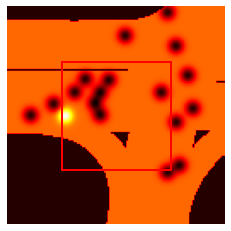

In [11]:
gt = (data["goal_pixel"])

oblist = dataset[idx]["ocg"]
obnum = dataset[idx]["obj_num"]
#print(oblist)
#print(oblist.shape[0])

new_map = gaussian(gt[0],gt[1], 128, 128, sigma=3)

obj_map = negative_gaussian(oblist,obnum, 128, 128,sigma=3)

new_map = 0.5*np.ones((128,128)) + new_map + obj_map

road_mask = dataset[idx]["road_mask"]#[28:84,28:84]
new_map[np.where(road_mask==0)] = 0

rect = patches.Rectangle((32, 32), 64, 64, linewidth=2, edgecolor='r', facecolor='none')
fig, ax = plt.subplots()

ax.add_patch(rect)

plt.axis("off")
#plt.figure(figsize=(10,10))
plt.imshow(new_map,  cmap=plt.get_cmap('hot'))



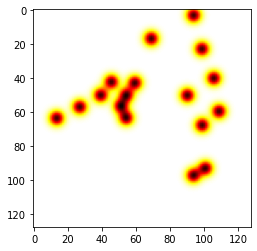

In [13]:
import matplotlib.patches as patches

rect = patches.Rectangle((32, 32), 64, 64, linewidth=1, edgecolor='r', facecolor='none')
#fig, ax = plt.subplots()

# Add the patch to the Axes
#ax.add_patch(rect)

plt.imshow(obj_map,  cmap=plt.get_cmap('hot'))


In [ ]:
from torch.utils.data import DataLoader

train_cfg = cfg["val_data_loader"]
print(train_cfg["batch_size"])
train_dataloader = DataLoader(dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])

data_ego = next(iter(train_dataloader))

In [ ]:

import torch

def batch_gaussian_tensor_obj(xL, yL, H, W, obj_list, obj_num, road_mask,  device, sigma=5 ):

 #channel = torch.zeros((H*W), dtype=torch.float)#.to("cuda:0")
    batch_size = xL.shape[0]
    channel = torch.full((batch_size, H, W), 0.5).to(device)

    x = torch.arange(H).view(H,1).repeat(1,W).to(device)
    y = torch.arange(W).repeat(H,1).to(device)

    for i in range(batch_size):
        channel[i] += 0.5*torch.exp((-((x - xL[i]) ** 2 + (y - yL[i]) ** 2) / (2 * sigma ** 2)))
        
        
        obnum = obj_num[i]
        for j in range(obnum):
            xy = obj_list[i][j]
            xo = xy[1]
            yo = xy[0]
            channel[i] += -0.5*torch.exp((-((x - xo) ** 2 + (y - yo) ** 2) / (2 * sigma ** 2)))
        
        channel[i][(road_mask[i]==0)] = 0
           
           
    return channel

gt_goal_positions_pixels = data_ego["goal_pixel"]
batch_road_mask = data_ego["road_mask"] # torch.permute(data_ego["road_mask"],(0,2,1))

import time
start = time.time()
gt_map_tensor = batch_gaussian_tensor_obj(gt_goal_positions_pixels[:,1], gt_goal_positions_pixels[:,0], 128, 128, data_ego["ocg"], data_ego["obj_num"], batch_road_mask,sigma=2,device="cuda:0")

print(time.time()-start)
# it takes 0.1 seconds

heatmap = gt_map_tensor[0].view(128,128).cpu().numpy()

#heatmap = batch_road_mask[0]

print(data_ego["road_mask"][0].dtype)
plt.imshow(heatmap, cmap='hot')

#plt.show()
#batch_weight = torch.where(gt_map_tensor[0].view(128,128) != 0.5, 1.0, 0.8)
#plt.imshow(batch_weight.cpu().numpy(), cmap='hot')

In [ ]:

idx = 17907
data = dataset[idx]



#im = data["image"].transpose(1, 2, 0)
im = data["image"].transpose(1,2,0)
im = dataset.rasterizer.to_rgb(im)

target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])


plt.imshow(im)
plt.show()

#data = dataset[idx]


ocg = data["ocg"]
import cv2
for i in ocg:
#    print(i)
    cv2.circle(im, (int(i[0]), int(i[1])), radius=1, color=(255, 0, 0), thickness=-1)

plt.imshow(im)
plt.show()


In [ ]:
idx = 17907
data = dataset[idx]



#im = data["image"].transpose(1, 2, 0)
im = data["image"].transpose(1,2,0)
im = dataset.rasterizer.to_rgb(im)

target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])
plt.imshow(im)
plt.show()

In [ ]:
print((agent_aux["track_id"]))